In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [191]:
df = pd.read_csv('/content/drive/MyDrive/UU/ETH-USD (BaoCao).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [192]:

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [193]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [194]:

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [195]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 non-null   float64
 3   Close      1920 non-null   float64
 4   Adj Close  1920 non-null   float64
 5   Volume     1920 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.0 KB


In [196]:


cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Correct the column name 'Adj Close'
df = df[cols]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [197]:




from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def calculate_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each variable."""
    vif_df = pd.DataFrame()
    vif_df["variables"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def cointegration_test(df, alpha=0.05, max_vif=10):
    """Perform Johanson's Cointegration Test and Report Summary"""
    # Convert numeric columns to float
    df_numeric = df.select_dtypes(include=['number']).astype(float)

    # Drop any columns with all zero values
    df_numeric = df_numeric.loc[:, (df_numeric != 0).any(axis=0)]

    # Drop constant columns to handle perfect multicollinearity
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()]

    # Calculate VIF and drop columns with VIF higher than the threshold
    while True:
        vif_df = calculate_vif(df_numeric)
        max_vif_value = vif_df['VIF'].max()
        if max_vif_value > max_vif:
            remove_col = vif_df.sort_values('VIF', ascending=False)['variables'].iloc[0]
            print(f"Removing {remove_col} with VIF {max_vif_value}")
            df_numeric = df_numeric.drop(columns=[remove_col])
        else:
            break

    out = coint_johansen(df_numeric, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_numeric.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

# Example usage with your dataframe df
cointegration_test(df)

Removing Close with VIF inf
Removing High with VIF 4687.121442316028
Removing Low with VIF 1967.2441891579692
Removing Open with VIF 548.7024682751013
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Adj Close ::  14.65     > 12.3212   =>   True
Volume ::  0.0       > 4.1296    =>   False


In [198]:


df = df.sort_values(by='Date', ascending=True)

In [223]:

# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

time_series = df[cols]
train_data = time_series[:int(0.8*len(time_series))]
test_data = time_series[int(0.8*len(time_series)):]

Error fitting model with lag 2. Skipping.
Error fitting model with lag 7. Skipping.


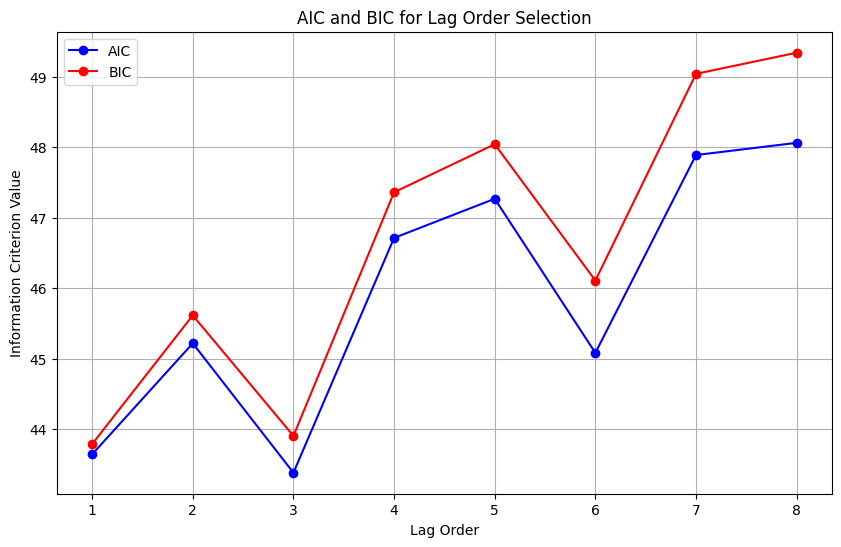

Optimal lag order based on AIC: 3
Optimal lag order based on BIC: 1


In [224]:


from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic
import numpy as np

# Tạo danh sách các giá trị lag order cần kiểm tra
maxlags = 10  # Số lượng lag order tối đa để kiểm tra

# Khởi tạo list để lưu trữ các giá trị AIC và BIC
aic_values = []
bic_values = []

for lag in range(1, maxlags+1):
    model = VAR(train_data)
    try:
        results = model.fit(lag)
        aic_values.append(results.aic)
        bic_values.append(results.bic)
    except np.linalg.LinAlgError:
        print(f"Error fitting model with lag {lag}. Skipping.")
        continue  # Skip to the next lag if an error occurs

# Vẽ đồ thị AIC và BIC (only if any models were successfully fit)
if aic_values:  # Check if aic_values is not empty
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(range(1, len(aic_values) + 1), aic_values, marker='o', linestyle='-', color='b', label='AIC')
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='r', label='BIC')
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion Value')
    plt.title('AIC and BIC for Lag Order Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tìm lag order tối ưu dựa trên AIC hoặc BIC
    optimal_lag_aic = np.argmin(aic_values) + 1  # +1 vì index bắt đầu từ 0
    optimal_lag_bic = np.argmin(bic_values) + 1  # +1 vì index bắt đầu từ 0

    print(f'Optimal lag order based on AIC: {optimal_lag_aic}')
    print(f'Optimal lag order based on BIC: {optimal_lag_bic}')
else:
    print("No models could be fit successfully. Check for multicollinearity or singularity issues in your data.")

In [225]:

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [226]:
# ADF Test on each column
df_diff = df.diff().dropna()  # Calculate first differences and drop missing values

for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8376
 No. Lags Chosen       = 16
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3895
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [227]:
import warnings
warnings.filterwarnings("ignore")

In [228]:

df_diff = train_data.diff().dropna()
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-02,-0.486161,-1.810471,-3.998398,-2.236664,-2.236664,-8.948399e+06
2019-03-03,-1.563964,-1.335510,-1.107529,-1.957535,-1.957535,-2.928024e+08
2019-03-04,-2.628235,-3.120148,-5.926155,-4.475296,-4.475296,5.537973e+08
2019-03-05,-4.364930,5.500839,1.332596,10.048264,10.048264,7.566786e+08
2019-03-06,10.165787,1.738846,9.410622,0.966964,0.966964,-1.757958e+08
...,...,...,...,...,...,...
2023-05-10,-0.847534,26.132813,-37.238159,-6.201660,-6.201660,3.816034e+09
2023-05-11,-5.721436,-44.308228,-21.536255,-45.910888,-45.910888,-1.591721e+09
2023-05-12,-47.315429,-30.067138,-31.728759,11.529174,11.529174,6.933703e+08


In [229]:

# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7826
 No. Lags Chosen       = 16
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9615
 No. Lags Chosen       = 22
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [230]:


model = VAR(df_diff)

In [231]:




import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_diff is your differenced DataFrame

# ADF Test on each column
for name, column in df_diff.items():
    result = adfuller(column) # Remove the 'name' argument
    print(f'ADF Statistic for {name}: {result[0]}') # Use f-string to print the name
    print(f'p-value: {result[1]}')
    print('\n')

# Check for multicollinearity
correlation_matrix = df_diff.corr()
print(correlation_matrix)

ADF Statistic for Open: -9.782642135734678
p-value: 6.670074827602447e-17


ADF Statistic for High: -7.961506930920689
p-value: 2.940134046468877e-12


ADF Statistic for Low: -11.252314802547797
p-value: 1.7000661898058476e-20


ADF Statistic for Close: -9.84951240071893
p-value: 4.5249549383745457e-17


ADF Statistic for Adj Close: -9.84951240071893
p-value: 4.5249549383745457e-17


ADF Statistic for Volume: -9.489842997385923
p-value: 3.677839733073435e-16


               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.591670  0.366293 -0.075632  -0.075632  0.099669
High       0.591670  1.000000  0.455782  0.484844   0.484844  0.218965
Low        0.366293  0.455782  1.000000  0.620124   0.620124 -0.426261
Close     -0.075632  0.484844  0.620124  1.000000   1.000000 -0.180213
Adj Close -0.075632  0.484844  0.620124  1.000000   1.000000 -0.180213
Volume     0.099669  0.218965 -0.426261 -0.180213  -0.180213  1.000000


In [232]:
fitted_model = model.fit() # Fit the VAR model and store it

lag_order = fitted_model.k_ar
print(lag_order)

1


In [233]:

predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 5.13365755e+00, -3.09266347e+00, -4.66435470e+00,
        -8.24603156e-01, -8.24603156e-01,  2.03290346e+08],
       [-1.25873098e+00,  2.84607013e+00,  5.55145634e+00,
         2.50273932e+00,  2.50273932e+00, -1.68317922e+08],
       [ 2.76436348e+00,  6.20875036e-01, -1.81034093e+00,
         2.10332993e-01,  2.10332993e-01,  9.97438663e+07],
       ...,
       [ 1.08579588e+00,  1.09836632e+00,  1.08092693e+00,
         1.08541179e+00,  1.08541179e+00,  7.15308039e+05],
       [ 1.08579588e+00,  1.09836632e+00,  1.08092693e+00,
         1.08541179e+00,  1.08541179e+00,  7.15308039e+05],
       [ 1.08579588e+00,  1.09836632e+00,  1.08092693e+00,
         1.08541179e+00,  1.08541179e+00,  7.15308039e+05]])

In [234]:





# Calculate the starting index based on the length of the predictions array
start_index = len(df) - len(predictions)

df_forecast = pd.DataFrame(predictions, index=df.index[start_index:], columns=[col + '_1d' for col in df.columns])
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d
Date,,,,,,
2023-05-15,5.133658,-3.092663,-4.664355,-0.824603,-0.824603,2.032903e+08
2023-05-16,-1.258731,2.846070,5.551456,2.502739,2.502739,-1.683179e+08
2023-05-17,2.764363,0.620875,-1.810341,0.210333,0.210333,9.974387e+07
2023-05-18,0.054385,1.161577,2.884490,1.574656,1.574656,-5.000472e+07
2023-05-19,1.666279,1.142198,-0.019626,0.824367,0.824367,2.566364e+07
...,...,...,...,...,...,...
2024-05-28,1.085796,1.098366,1.080927,1.085412,1.085412,7.153080e+05
2024-05-29,1.085796,1.098366,1.080927,1.085412,1.085412,7.153080e+05
2024-05-30,1.085796,1.098366,1.080927,1.085412,1.085412,7.153080e+05


In [235]:



def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns  # Get the actual column names from df_train
    for col in columns:
        # Use the correct column names from df_train when creating forecasted columns
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_data, df_forecast)
# Now, define fc_cols based on the actual forecasted column names
fc_cols = [col + '_forecast' for col in train_data.columns]
df_results = df_results[fc_cols]
df_results

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,
2023-05-15,1801.241568,1820.398060,1788.564405,1799.676374,1799.676374,4.914501e+09
2023-05-16,1799.982837,1823.244130,1794.115862,1802.179113,1802.179113,4.746183e+09
2023-05-17,1802.747200,1823.865005,1792.305521,1802.389446,1802.389446,4.845927e+09
2023-05-18,1802.801585,1825.026582,1795.190010,1803.964102,1803.964102,4.795922e+09
2023-05-19,1804.467864,1826.168780,1795.170384,1804.788469,1804.788469,4.821585e+09
...,...,...,...,...,...,...
2024-05-28,2211.436965,2238.026103,2200.932039,2211.907927,2211.907927,5.081640e+09
2024-05-29,2212.522760,2239.124469,2202.012966,2212.993339,2212.993339,5.082355e+09
2024-05-30,2213.608556,2240.222836,2203.093893,2214.078750,2214.078750,5.083071e+09


In [236]:

# Forecasting 30 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=30, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_30days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_30days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.445204  44.367134  32.712209 -5.983601     -5.983601   
2024-06-03  -5.334067  -9.944041 -13.603416 -0.334376     -0.334376   
2024-06-04  -0.898163   3.620834   9.165308  3.308275      3.308275   
2024-06-05   3.682638   0.895067  -3.457754 -0.263116     -0.263116   
2024-06-06  -0.490489   0.944148   3.792650  1.787553      1.787553   

               Volume_1d  
2024-06-02  7.736514e+08  
2024-06-03  4.671523e+08  
2024-06-04 -3.227224e+08  
2024-06-05  1.565012e+08  
2024-06-06 -6.832292e+07  


In [237]:


def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Create forecasted columns using '_forecast' suffix
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)

# Define fc_cols based on the actual forecasted column names in df_results_30days
fc_cols = [col for col in df_results_30days.columns if '_forecast' in col]
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.329481,3873.661812,3782.552297,3807.215374,3807.215374,9.434676e+09
2024-06-03,3805.995414,3863.717772,3768.948881,3806.880998,3806.880998,9.901828e+09
2024-06-04,3805.097252,3867.338606,3778.114188,3810.189273,3810.189273,9.579106e+09
2024-06-05,3808.779890,3868.233673,3774.656434,3809.926157,3809.926157,9.735607e+09
2024-06-06,3808.289401,3869.177821,3778.449084,3811.713710,3811.713710,9.667284e+09


In [238]:
df_results_30days = invert_transformation(test_data, df_forecast_30days)
df_results_30days = df_results_30days[fc_cols]
df_results_30days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.329481,3873.661812,3782.552297,3807.215374,3807.215374,9.434676e+09
2024-06-03,3805.995414,3863.717772,3768.948881,3806.880998,3806.880998,9.901828e+09
2024-06-04,3805.097252,3867.338606,3778.114188,3810.189273,3810.189273,9.579106e+09
2024-06-05,3808.779890,3868.233673,3774.656434,3809.926157,3809.926157,9.735607e+09
2024-06-06,3808.289401,3869.177821,3778.449084,3811.713710,3811.713710,9.667284e+09
2024-06-07,3810.208748,3870.435231,3777.903147,3812.443665,3812.443665,9.699536e+09
2024-06-08,3810.864832,3871.416484,3779.947503,3813.711495,3813.711495,9.685189e+09
2024-06-09,3812.174604,3872.594790,3780.467377,3814.701871,3814.701871,9.693293e+09
2024-06-10,3813.142238,3873.640966,3781.870415,3815.837165,3815.837165,9.690359e+09
2024-06-11,3814.290723,3874.772176,3782.768473,3816.896359,3816.896359,9.692870e+09


In [239]:

# Forecasting 60 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=60)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=60, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_60days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_60days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.445204  44.367134  32.712209 -5.983601     -5.983601   
2024-06-03  -5.334067  -9.944041 -13.603416 -0.334376     -0.334376   
2024-06-04  -0.898163   3.620834   9.165308  3.308275      3.308275   
2024-06-05   3.682638   0.895067  -3.457754 -0.263116     -0.263116   
2024-06-06  -0.490489   0.944148   3.792650  1.787553      1.787553   

               Volume_1d  
2024-06-02  7.736514e+08  
2024-06-03  4.671523e+08  
2024-06-04 -3.227224e+08  
2024-06-05  1.565012e+08  
2024-06-06 -6.832292e+07  


In [240]:

df_results_60days = invert_transformation(test_data, df_forecast_60days)
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.329481,3873.661812,3782.552297,3807.215374,3807.215374,9.434676e+09
2024-06-03,3805.995414,3863.717772,3768.948881,3806.880998,3806.880998,9.901828e+09
2024-06-04,3805.097252,3867.338606,3778.114188,3810.189273,3810.189273,9.579106e+09
2024-06-05,3808.779890,3868.233673,3774.656434,3809.926157,3809.926157,9.735607e+09
2024-06-06,3808.289401,3869.177821,3778.449084,3811.713710,3811.713710,9.667284e+09
2024-06-07,3810.208748,3870.435231,3777.903147,3812.443665,3812.443665,9.699536e+09
2024-06-08,3810.864832,3871.416484,3779.947503,3813.711495,3813.711495,9.685189e+09
2024-06-09,3812.174604,3872.594790,3780.467377,3814.701871,3814.701871,9.693293e+09
2024-06-10,3813.142238,3873.640966,3781.870415,3815.837165,3815.837165,9.690359e+09
2024-06-11,3814.290723,3874.772176,3782.768473,3816.896359,3816.896359,9.692870e+09


In [241]:

# Forecasting 90 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=90)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=90, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_90days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_90days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.445204  44.367134  32.712209 -5.983601     -5.983601   
2024-06-03  -5.334067  -9.944041 -13.603416 -0.334376     -0.334376   
2024-06-04  -0.898163   3.620834   9.165308  3.308275      3.308275   
2024-06-05   3.682638   0.895067  -3.457754 -0.263116     -0.263116   
2024-06-06  -0.490489   0.944148   3.792650  1.787553      1.787553   

               Volume_1d  
2024-06-02  7.736514e+08  
2024-06-03  4.671523e+08  
2024-06-04 -3.227224e+08  
2024-06-05  1.565012e+08  
2024-06-06 -6.832292e+07  


In [242]:

df_results_90days = invert_transformation(test_data, df_forecast_90days)
df_results_90days = df_results_90days[fc_cols]
df_results_90days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.329481,3873.661812,3782.552297,3807.215374,3807.215374,9.434676e+09
2024-06-03,3805.995414,3863.717772,3768.948881,3806.880998,3806.880998,9.901828e+09
2024-06-04,3805.097252,3867.338606,3778.114188,3810.189273,3810.189273,9.579106e+09
2024-06-05,3808.779890,3868.233673,3774.656434,3809.926157,3809.926157,9.735607e+09
2024-06-06,3808.289401,3869.177821,3778.449084,3811.713710,3811.713710,9.667284e+09
...,...,...,...,...,...,...
2024-08-26,3896.789465,3958.235489,3864.984885,3899.396684,3899.396684,9.746643e+09
2024-08-27,3897.875260,3959.333855,3866.065812,3900.482096,3900.482096,9.747359e+09
2024-08-28,3898.961056,3960.432222,3867.146739,3901.567508,3901.567508,9.748074e+09
2024-08-29,3900.046852,3961.530588,3868.227666,3902.652919,3902.652919,9.748789e+09


In [243]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

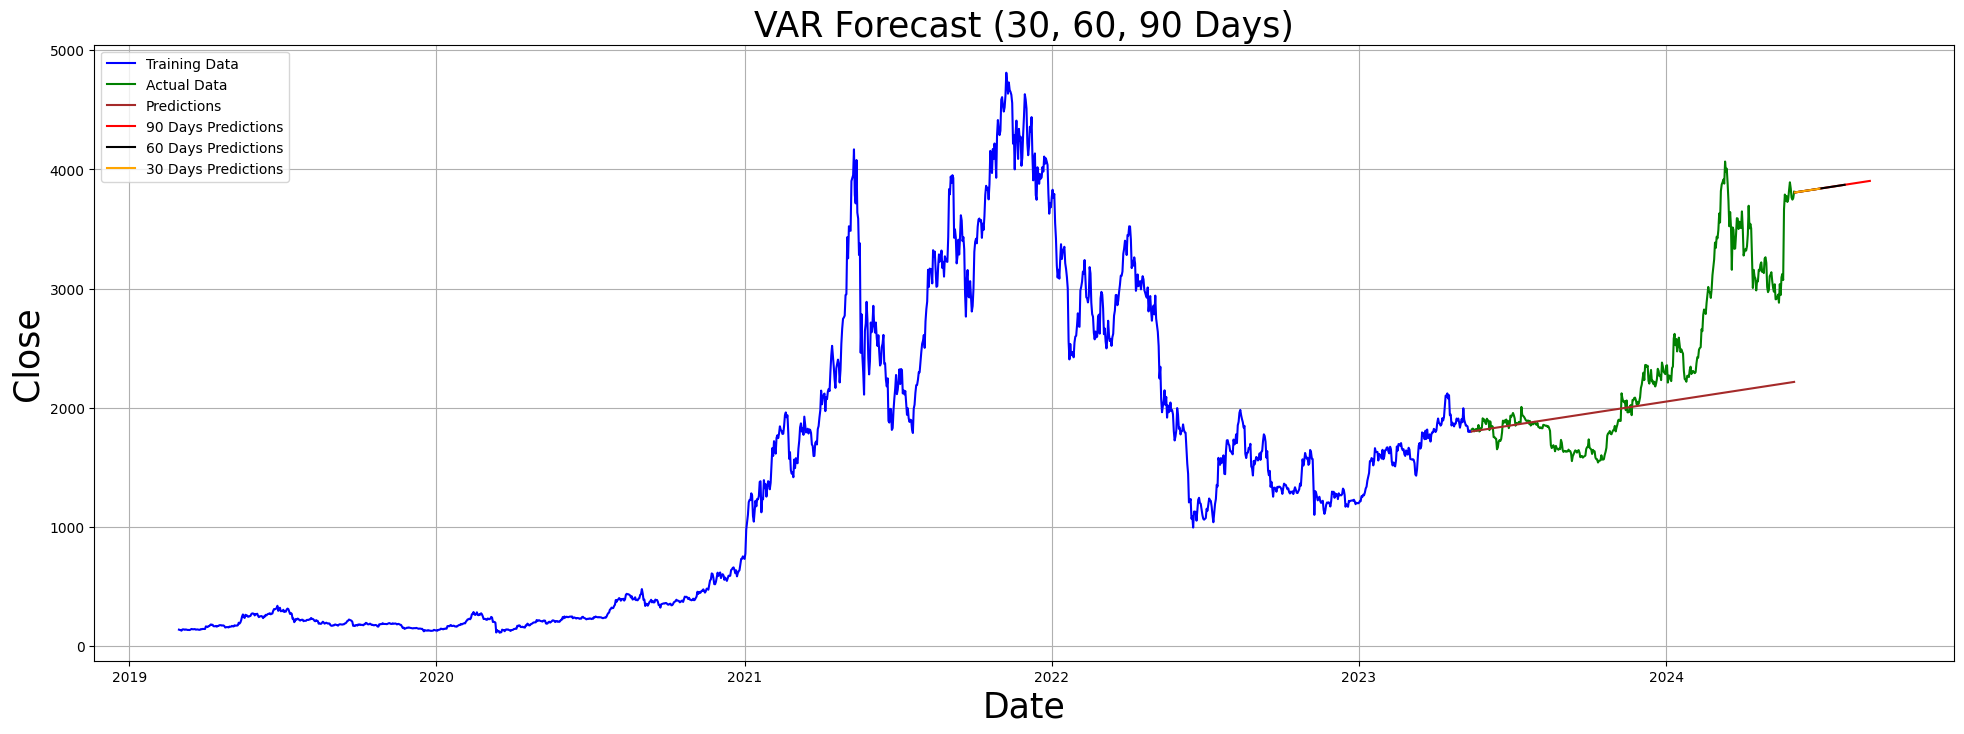

In [244]:


import matplotlib.pyplot as plt

# Assuming df_results_30days, df_results_60days, df_results_90days are your DataFrames containing forecast results
# Define the date range for plotting
start_date = '2019-01-03'
end_date = '2024-08-30'

# Plotting the data
plt.figure(figsize=(24, 8))

# Plotting the training data
plt.plot(train_data.index, train_data.Close, label='Training Data', color='blue')

# Plotting the actual test data
plt.plot(test_data.index, test_data.Close, label='Actual Data', color='green')
# Plotting the prediction data
plt.plot(test_data.index, df_results.Close_forecast, label='Predictions', color ='brown')
# Plotting the forecast results

plt.plot(df_results_90days.index, df_results_90days.Close_forecast, label='90 Days Predictions', color='red')

plt.plot(df_results_60days.index, df_results_60days.Close_forecast, label='60 Days Predictions', color='black')
plt.plot(df_results_30days.index, df_results_30days.Close_forecast, label='30 Days Predictions', color='orange')
# Adding title and labels
plt.title('VAR Forecast (30, 60, 90 Days)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Close', fontsize=25)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [245]:

y_test = test_data.Close
y_pred = df_results.Close_forecast

In [246]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



test_91_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_91_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_91_mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print('Testing RMSE:', test_91_rmse)
print('Testing MAPE:', test_91_mape)
print('Testing MSE:', test_91_mse)

Testing RMSE: 683.960748320778
Testing MAPE: 16.674124418349443
Testing MSE: 467802.3052435185
